# DRAFT: Comparing ML model (built in or same as Simba) interaction times to gold standard holdout set and stopwatch human data

NOTE: "score" will refer to binary f1, precision, and/or recall.  Relative to the target class, "Interaction".

Goal:  
- Build a classifier based on the same procedure as Simba.  
- Score via per-video cross validation during training, to estimate the generalization accuracy for unseen videos.
- Score at each step of processing:
    - Building the classifier
    - min_bought_duratin post processing
    - Kleinburg Filtering post processing
- Compare to stop watched labelled human data.
- Analyze the distribution of errors relative to each individual object, each treatment class, and each rat.
    - Ideally the errors will have no bias and be zero mean Guassian across each categorical split.

## Class Definitions

In [108]:
import pandas as pd
import numpy
import glob
import os
import functools

## Dataset class to encapsulate opening files and creating cv_indexes required for running cross_validation in sklearn
## on a per video basis.  We will also encapsulate handling individual Dataframes per video vs. one large Dataframe
## with all the videos.  The large Dataframe

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from collections import namedtuple

PartialResults = namedtuple(
    'PartialResults',
    'precision recall f1 c_mat')
# TODO: FullResults appears to be unused!
FullResults = namedtuple(
    'FullResults',
    'model test_results train_results total_time')

def build_partial_result(y_true, y_pred):
    try:
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    except:
        # must be multi class
        classes = sorted(x for x in numpy.unique(y_true) if x != 0) # Exclude the majority class
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=classes, average='weighted')
    # precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    c_mat = confusion_matrix(y_true, y_pred)
    return PartialResults(precision, recall, f1, c_mat)

class ModelResultLabels(object):
    """ Another data class for holding results """
    def __init__(self, func, y_binary, y_multi, y_prob, binary_results, multi_label_results):
        self._func = func # just in case, will use name for printing
        self.y_binary = y_binary
        self.y_multi = y_multi
        self.y_prob = y_prob # Probability will always be relative to the binary labels.
        self.binary_results: PartialResults = binary_results
        self.multi_label_results: PartialResults = multi_label_results

class PerVideoDataClass(object):
    """ The Dataset class will aggregate 1 instance of this class for each video it manages. """
    def __init__(self, file_path, df, x_extractor, y_binary_label_extractor, y_multi_label_extractor):
        self.file_path = file_path # just in case
        self.video_name = os.path.splitext(os.path.basename(file_path))[0] # the video name contains meta data about animal and treatment group etc.
        if video_name_map is not None:
            if self.video_name in video_name_map:
                self.video_name = video_name_map[self.video_name]
            elif self.video_name not in video_name_map.values():
                msg = f'WARNING: Found a video name that is not in the video_name_map!!! (should be either a new name, or an old name with a mapped name): {self.video_name}'
                print(msg)
                raise RuntimeError(msg)
        # self.video_metadata = VideoMetadata.from_name(self.video_name)
        self.video_metadata = None # TODO: Put the meta-data on the per video class??
        self.X = x_extractor(df)
        self.y_binary = y_binary_label_extractor(df) # The test labels.
        self.y_multi = y_multi_label_extractor(df, self.y_binary)
        self._y_multi_label_extractor = functools.partial(y_multi_label_extractor, df) # need for later, the rest can go.
        from collections import OrderedDict, defaultdict
        # Dictionary with keys being classifier descriptions (tuples, or other hashable types that describe your classifier),
        # and values being ordered dictionaries.
        self.model_result_labels = defaultdict(OrderedDict)
    
    def apply_and_record_postprocessing_step(self, classifier_desc, func, y_binary, y_prob=None):
        """ Func was used to produce y_binary, we record the results for analysis later. """
        if isinstance(func, str):
            # Kinda hacky, oh well
            step_key = func
        elif callable(func):
            step_key = func.__name__
        else:
            step_key = func.__class__.__name__
        y_multi = self._y_multi_label_extractor(y_binary)
        self.model_result_labels[classifier_desc][step_key] = ModelResultLabels(
            func, y_binary, y_multi, y_prob, 
            build_partial_result(self.y_binary, y_binary),
            build_partial_result(self.y_multi, y_multi))

    def __str__(self):
        return f'''
        Video name: {self.video_name}
        Results stored: {self.model_result_labels.keys()}
        '''

    def __repr__(self):
        return str(self)

class Dataset(object):
    def __init__(self, per_video_data_classes):
        self.per_video_data_classes = per_video_data_classes

    @classmethod
    def from_scratch(cls, input_files, x_extractor, y_binary_label_extractor, y_multi_label_extractor):
        # assert isinstance(input_files, list)
        dfs = [pd.read_csv(f, index_col=0) for f in input_files]
        # self._original_dfs = dfs # Just in case
        per_video_data_classes = [
            PerVideoDataClass(
                file_path,
                df, 
                x_extractor=x_extractor,
                y_binary_label_extractor=y_binary_label_extractor,
                y_multi_label_extractor=y_multi_label_extractor)
            for file_path, df in zip(input_files, dfs)
        ]
        return cls(per_video_data_classes)

    @property
    def data_files(self):
        return [per_video_data.file_path for per_video_data in self.per_video_data_classes]

    def __str__(self):
        files_str = '\n\t'.join(self.data_files)
        paths_str = f'Data files: {files_str}'
        return f'{self.__class__.__name__}:\n' \
               f'Number of files: {len(self.data_files)}\n' \
               f'Paths: {paths_str}'

## Pre Processing:
## All we need to do is select the desired input features, and the target columns

## Define specific extraction methods.
def build_Y_get_interaction(col='Interaction'):
    """ For the objects datasets """
    def Y_get_interaction(df: pd.DataFrame):
        ys = df[col]
        ys = ys.fillna(value=0.0)
        return ys.values
    return Y_get_interaction


def build_Y_get_multi_label(distance_features):
    def Y_get_multi_label(df, ys_binary):
        # +1 Because column_0 ==>  Object_1
        nearest_obj = df[distance_features].values.argmin(axis=1) + 1
        return nearest_obj * ys_binary
    return Y_get_multi_label

# x extractors
def build_X_extractor(input_features):
    def X_extractor(df):
        # input_features should be a set of columns known to be in the Dataframe.
        return df[input_features]
    return X_extractor






## Load video name map into global env

In [109]:
# TODO: Waiting on video_name_map from Tim/Ilne
video_name_map = None

## Load csv Data

In [110]:

interaction_features = [
    'Interaction',
    'Probability_Interaction'
]

raw_dlc_features_only = [
    "Ear_left_p",
    "Ear_left_x",
    "Ear_left_y",

    "Ear_right_p",
    "Ear_right_x",
    "Ear_right_y",

    "Lat_left_p",
    "Lat_left_x",
    "Lat_left_y",

    "Lat_right_p",
    "Lat_right_x",
    "Lat_right_y",

    "Center_p",
    "Center_x",
    "Center_y",

    "Nose_p",
    "Nose_x",
    "Nose_y",

    "Tail_base_p",
    "Tail_base_x",
    "Tail_base_y",

    "Tail_end_x",
    "Tail_end_y",
    "Tail_end_p",
]

## Load the data.  Pre engineered features created in Simba with Region of Interest (ROI) data included.
## ROI data is centered on each of 6 objects of interest.
training_simba_csv_files = glob.glob(
    os.path.join('hackathon', 'Iteration_2_withROI', 'targets_inserted', '*.csv'))
holdout_simba_csv_files = glob.glob(
    os.path.join('hackathon', 'Iteration_2_withROI', 'hold_dataset', '*.csv'))

# # TEMP: Only 1 each for now while coding
# training_simba_csv_files = training_simba_csv_files[0:2]
# holdout_simba_csv_files = holdout_simba_csv_files[0:2]

# temporary Dataframe so we can read the columns.
temp_df = pd.read_csv(training_simba_csv_files[0], index_col=0)
temp_df_cols = set(temp_df.columns)
# The following cols are not in new dfs, we will drop them
cols_to_drop = ['Stimulus 6 Animal_1 in zone_cumulative_percent', 'Stimulus 1 Animal_1 in zone_cumulative_percent', 'Stimulus 2 Animal_1 in zone_cumulative_percent', 'Stimulus 3 Animal_1 in zone_cumulative_time', 'Stimulus 5 Animal_1 in zone_cumulative_percent', 'Stimulus 6 Animal_1 in zone_cumulative_time', 'Stimulus 3 Animal_1 in zone_cumulative_percent', 'Stimulus 1 Animal_1 in zone_cumulative_time', 'Stimulus 5 Animal_1 in zone_cumulative_time', 'Stimulus 2 Animal_1 in zone_cumulative_time', 'Stimulus 4 Animal_1 in zone_cumulative_percent', 'Stimulus 4 Animal_1 in zone_cumulative_time']

# for csv_file in training_simba_csv_files + holdout_simba_csv_files:
#     cur_df = pd.read_csv(csv_file, nrows=2, index_col=0)
#     cur_df_cols = set(cur_df.columns)
#     sym_diff = cur_df_cols.symmetric_difference(temp_df_cols)
#     if sym_diff:
#         print(f'Found differences in cols for {csv_file}')
#         print(f'Cols in temp_df but not curr: {sym_diff - cur_df_cols}')
#         print(f'Cols in curr_df but not temp: {sym_diff - temp_df_cols}')
#         raise RuntimeError('Not happy with columns')

exclude_columns = interaction_features + raw_dlc_features_only + cols_to_drop
input_features = [col for col in temp_df.columns if col not in exclude_columns]
x_extractor = build_X_extractor(input_features)
y_binary_label_extractor = build_Y_get_interaction(col='Interaction')

import re
distance_re = re.compile(r'^Stimulus [0-9] Animal_[0-9]+ distance$')
# 
distance_features = [col for col in temp_df.columns if distance_re.match(col)]
print('ROI_features:', distance_features)
y_multi_label_extractor = build_Y_get_multi_label(distance_features)

# def apply_and_record_postprocessing_step(self, func, y_binary): # Don't forget to use this later

training_dataset = Dataset.from_scratch(training_simba_csv_files, x_extractor, y_binary_label_extractor, y_multi_label_extractor)
# We don't make cv indexes for the holdout set because we will only be using this to verify
# model performance on unseen videos.
holdout_dataset = Dataset.from_scratch(holdout_simba_csv_files, x_extractor, y_binary_label_extractor, y_multi_label_extractor)

ROI_features: ['Stimulus 1 Animal_1 distance', 'Stimulus 2 Animal_1 distance', 'Stimulus 3 Animal_1 distance', 'Stimulus 4 Animal_1 distance', 'Stimulus 5 Animal_1 distance', 'Stimulus 6 Animal_1 distance']


In [111]:

iteration_3_csv_files = glob.glob(
    os.path.join('hackathon', 'Iteration_3_withSimbaModelLabels', 'machine_results_object', '*'))
simba_prelabeled_dataset = Dataset.from_scratch(iteration_3_csv_files, x_extractor, y_binary_label_extractor, y_multi_label_extractor)

In [112]:
# [x.replace('\\', '/') for x in holdout_dataset.data_files] + [x.replace('\\', '/') for x in training_dataset.data_files]

## Load Video Metadata and split by Odour/Object

In [113]:

# TODO: Load the unlabeled set?
# TODO: Load and record the video meta-data for each

class VideoMetadata(object):
    def __init__(self, video_name, *, rat_id, stimuli_type, task_variation, treatment, novel_id, date, extra):
        # TODO: Video stub name? Or with extension? A path ever??
        # 'phase' == 'task_variation'
        self.video_name = video_name
        self.rat_id = rat_id
        self.stimuli_type = stimuli_type
        self.task_variation = task_variation
        self.treatment = treatment
        self.novel_id = novel_id
        self.date = date
        self.extra = extra

    def __str__(self):
        return f'''
        Video Name: {self.video_name}
        Rat ID: {self.rat_id}
        Stimuli Type: {self.stimuli_type}
        Task Variation: {self.task_variation}
        Treatment: {self.treatment}
        Novel ID: {self.novel_id}
        Date (of recording): {self.date}
        Extra (notes): {self.extra}
        '''

    @classmethod
    def from_name(cls, video_name):
        # ex: 2022-06-11_NOD_DOT_9
        nod_nob_to_stimuli_type = {
            'NOD': 'Odour',
            'NOB': 'Object'
        }
        parts = video_name.split('_')
        date, raw_NOD_NOB, task_variation, rat_id = parts[:4]
        stimuli_type = nod_nob_to_stimuli_type[raw_NOD_NOB] # If this errors out, name is malformed
        # Treatment is unknown... unless we get a rat_id -> treatment mapping...
        # Extra is not present from name alone...
        # Don't know what novel id is from video name alone...
        return cls(video_name, rat_id=rat_id, stimuli_type=stimuli_type,
                    task_variation=task_variation, treatment=None, novel_id=None, date=date, extra=None)


video_metadata_csv = os.path.join('hackathon', 'Iteration_2_withROI', 'trainingset_key.csv')
## TODO: Does this key have metadata for all the videos? Training set? Holdout set?
video_metadata_df = pd.read_csv(video_metadata_csv, index_col='File Name')
print(video_metadata_df.head())

def populate_video_metadata(dataset):
    for per_video_data in dataset.per_video_data_classes:
        try:
            row = video_metadata_df.loc[per_video_data.video_name]
            rat_id = row['Rat ID']
            stimuli_type = row['Stimuli Type']
            task_variation = row['Task Variation']
            novel_id = row['Novel ID']
            per_video_data.video_metadata = VideoMetadata(
                video_name=per_video_data.video_name,
                rat_id=rat_id,
                stimuli_type=stimuli_type,
                novel_id=novel_id,
                task_variation=task_variation,
                treatment=None,
                date=None,
                extra=None
                )

        except KeyError:
            video_metadata = VideoMetadata.from_name(per_video_data.video_name)
            print('Generated from video name:', video_metadata)
            per_video_data.video_metadata = video_metadata

populate_video_metadata(training_dataset)
populate_video_metadata(holdout_dataset)

training_odour_dataset = Dataset(
    [per_video_data for per_video_data in training_dataset.per_video_data_classes 
     if per_video_data.video_metadata.stimuli_type == 'Odour'])
training_object_dataset = Dataset(
    [per_video_data for per_video_data in training_dataset.per_video_data_classes 
     if per_video_data.video_metadata.stimuli_type == 'Object'])

holdout_odour_dataset = Dataset(
    [per_video_data for per_video_data in holdout_dataset.per_video_data_classes 
     if per_video_data.video_metadata.stimuli_type == 'Odour'])
holdout_object_dataset = Dataset(
    [per_video_data for per_video_data in holdout_dataset.per_video_data_classes 
     if per_video_data.video_metadata.stimuli_type == 'Object'])


training_combined_dataset = training_dataset # Only required for training xgb combined
# holdout_combined_dataset = holdout_dataset # Not required

print(f'Training object dataset: {training_object_dataset}')
print(f'Holdout object dataset: {holdout_object_dataset}')
print(f'Training odour dataset: {training_odour_dataset}')
print(f'Holdout odour dataset: {holdout_odour_dataset}')


del training_dataset
del holdout_dataset # LOL; Risky


                        Rat ID Stimuli Type Task Variation  Novel ID
File Name                                                           
08_11_2021_DOT_Rat7_8        7        Odour            DOT       NaN
08_12_2021_IOT_Rat3_4        3        Odour            IOT       NaN
08_13_2021_DOT_Rat9_10       9        Odour            DOT       NaN
08_14_2021_DOT_Rat7_8        8        Odour            DOT       NaN
2022-06-11_NOD_DOT_9         9        Odour            DOT       NaN
Generated from video name: 
        Video Name: 2022-06-26_NOB_IOT_5
        Rat ID: 5
        Stimuli Type: Object
        Task Variation: IOT
        Treatment: None
        Novel ID: None
        Date (of recording): 2022-06-26
        Extra (notes): None
        
Generated from video name: 
        Video Name: 03142021_NOB_DOT_5_upsidedown
        Rat ID: 5
        Stimuli Type: Object
        Task Variation: DOT
        Treatment: None
        Novel ID: None
        Date (of recording): 03142021
        Ext

# Fit the model
Okay, data is loaded, features and labels extracted and stored in two Dataset objects.
No we are ready to fit a model, and get some performance metrics!

In [114]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle

# From a previous GridSearchCV:
# 
# Finished training model; best_score: 0.4699529225702816; 
# best_estimator: XGBClassifier(base_score=0.5, booster='gbtree', gamma=0.0,
#               grow_policy='lossguide', interaction_constraints=None,
#               learning_rate=0.3, max_delta_step=1, max_depth=4,
#               min_child_weight=0, missing=None, n_estimators=300, n_jobs=14,
#               nthread=None, num_parallel_tree=1, objective='binary:logistic',
#               random_state=0, reg_alpha=0, reg_lambda=1,
#               sampling_method='gradient_based',
#               scale_pos_weight=4.296046179280971, seed=None, silent=None,
#               subsample=0.5, tree_method='gpu_hist', verbosity=1)
# Best grid search params: {'gamma': 0.0, 'learning_rate': 0.3, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 300, 'scale_pos_weight': 4.296046179280971}
#
# NOTE: scale_pos_weight will be fit with a bit of a trick for xgboost, based on the frequency of labels
#       in the input dataset.


# 1. Get all training Xs and ys from the dataset.  Use proportion in ys to set scale_pos_weight

def load_or_save(models_dir, train_new=False):
    def inner(func):
      def wrapper(dataset, classifier_desc):
        maybe_path = os.path.join('hackathon', models_dir, classifier_desc + '.pkl')
        if not train_new and maybe_path and os.path.isfile(maybe_path):
          print(f'Loading model from: {maybe_path}')
          with open(maybe_path, 'rb') as f:
            clf = pickle.load(f)
        else:
          print(f'Training new {classifier_desc} model')
          clf = func(dataset, classifier_desc)
          if maybe_path is not False:
            with open(maybe_path, 'wb') as clf_file:
                print(f'Saving to {maybe_path}')
                pickle.dump(clf, clf_file)
        return clf
      return wrapper
    return inner

@load_or_save('temp_xgb_models', train_new=True)
def train_xgb(dataset: Dataset, classifier_desc):
    Xs = []
    ys = []
    for per_video_data in dataset.per_video_data_classes:
        Xs.append(per_video_data.X)
        ys.append(per_video_data.y_binary) # use binary ys for training and predictions.

    Xs = pd.concat(Xs)
    # Xs = numpy.vstack(Xs)
    ys = numpy.hstack(ys)
    print('Fitting new xgb model...')
    new_scale_pos_weights = (ys == 0).sum() / (ys >= 1).sum()
    print('Sample weight applied to positive class:', new_scale_pos_weights)
    xgb_clf = XGBClassifier(base_score=0.5, booster='gbtree', gamma=0.0,
                  grow_policy='lossguide', learning_rate=0.3, max_delta_step=1, max_depth=4,
                  min_child_weight=0, missing=0, n_estimators=300, n_jobs=14,
                  objective='binary:logistic',
                  # objective='binary:logitraw',
                  tree_method='gpu_hist', sampling_method='gradient_based',
                  random_state=42, 
                  scale_pos_weight=new_scale_pos_weights, seed=42, silent=None,
                  subsample=0.5, 
                  verbosity=1)
    xgb_clf.fit(Xs, ys)
    xgb_clf._classifier_desc = classifier_desc
    return xgb_clf

@load_or_save('temp_RF_models', train_new=False)
def train_RF(dataset: Dataset, classifier_desc):
    Xs = []
    ys = []
    for per_video_data in dataset.per_video_data_classes:
        Xs.append(per_video_data.X)
        ys.append(per_video_data.y_binary) # use binary ys for training and predictions.

    rf_clf = RandomForestClassifier(
                  # n_estimators=200,
                  n_estimators=2000,
                  bootstrap=True,
                  verbose=0, # 1 if you want to see jobs etc
                  n_jobs=-1,
                  criterion='entropy',  # Gini is standard, shouldn't be a huge factor
                  min_samples_leaf=2,
                  max_features='sqrt',
                  # max_depth=15,  # LIMIT MAX DEPTH!!  Runtime AND generalization error should improve drastically
                  random_state=42,
                  #     ccp_alpha=0.005, # NEW PARAMETER, I NEED TO DEFINE MY EXPERIMENT SETUPS BETTER, AND STORE SOME RESULTS!!
                  # Probably need to whip up a database again, that's the only way I have been able to navigate this in the past
                  # Alternatively I could very carefully define my experiments, and then run them all in a batch and create a
                  # meaningful report.  This is probably the best way to proceed.  It will lead to the most robust iteration
                  # and progress.
                  ## NEW: Turning this on rather than under/over sampling.
                  class_weight='balanced',  # balance weights at nodes based on class frequencies
                )
    Xs = pd.concat(Xs)
    # Xs = numpy.vstack(Xs)
    ys = numpy.hstack(ys)
    print('Fitting new RF model...')
    rf_clf.fit(Xs, ys)
    rf_clf._classifier_desc = classifier_desc
    return rf_clf

xgb_odour_clf = train_xgb(training_odour_dataset, 'XGBClassifier_odour')
xgb_object_clf = train_xgb(training_object_dataset, 'XGBClassifier_object')
# xgb_combined_clf = train_xgb(training_combined_dataset, 'XGBClassifier_combined')

rf_odour_clf = train_RF(training_odour_dataset, 'RFClassifier_odour')
rf_object_clf = train_RF(training_object_dataset, 'RFClassifier_object')
# rf_combined_clf = train_RF(training_combined_dataset, 'RFClassifier_combined')
simba_odour_clf = rf_odour_clf
simba_object_clf = rf_object_clf

# If a path is provided we load a model file from disk, otherwise we fit a new one.
# model_path = 'TEMP_DecisionTreeModel_for_notebook.pkl' # Put path to your model here
## No longer loading simba models, out of date which causes errors.
# object_simba_model_path = os.path.join('hackathon', 'Iteration_2_withROI', 'models', 'object', 'Interaction.sav')
# odour_simba_model_path = os.path.join('hackathon', 'Iteration_2_withROI', 'models', 'odour', 'Interaction.sav')
# if object_simba_model_path and os.path.isfile(object_simba_model_path):
#   print(f'Loading model from: {object_simba_model_path}')
#   with open(object_simba_model_path, 'rb') as f:
#     simba_object_clf = pickle.load(f)
# if odour_simba_model_path and os.path.isfile(odour_simba_model_path):
#   print(f'Loading model from: {odour_simba_model_path}')
#   with open(odour_simba_model_path, 'rb') as f:
#     simba_odour_clf = pickle.load(f)


Training new XGBClassifier_odour model
Fitting new xgb model...
Sample weight applied to positive class: 3.8895560797769675
Saving to hackathon\temp_xgb_models\XGBClassifier_odour.pkl
Training new XGBClassifier_object model
Fitting new xgb model...
Sample weight applied to positive class: 4.09393063583815
Saving to hackathon\temp_xgb_models\XGBClassifier_object.pkl
Loading model from: hackathon\temp_RF_models\RFClassifier_odour.pkl
Loading model from: hackathon\temp_RF_models\RFClassifier_object.pkl


# Record Results and Apply Post Processing
Now we have a trained model.  We're going to define some post-processing functions that match what is provided in Simba and then record the results at each step (classifier labels, labels after min_bought_duration smoothing, 
and labels after Kleinburg Filtering).  Then we will calculate classifier performance at each of these steps.
Finally we will calculate total interaction times for each video, then aggregate the results per animal, per treatment group, and per object.

In [116]:
import numpy as np
import math

def kleinberg(offsets: np.ndarray, s=2, gamma=1):
    """ TODO: Cite/give credit to Simba devs for implementation"""
    if s <= 1:
        raise ValueError("s must be greater than 1'!")
    if gamma <= 0:
        raise ValueError("gamma must be positive!")
    if len(offsets) < 1:
        raise ValueError("offsets must be non-empty!")

    assert offsets.ndim == 1
    offsets = np.array(offsets, dtype=object)

    if offsets.size == 1:
        bursts = np.array([0, offsets[0], offsets[0]], ndmin=2, dtype=object)
        return bursts

    # offsets = np.sort(offsets)
    gaps = np.diff(offsets)

    if not np.all(gaps):
        raise ValueError("Input cannot contain events with zero time between!")

    T = np.sum(gaps)
    n = np.size(gaps)

    g_hat = T / n

    k = int(math.ceil(float(1 + math.log(T, s) + math.log(1 / np.amin(gaps), s))))

    gamma_log_n = gamma * math.log(n)

    def tau(i, j):
        if i >= j:
            return 0
        else:
            return (j - i) * gamma_log_n

    alpha_function = np.vectorize(lambda x: s ** x / g_hat)
    alpha = alpha_function(np.arange(k))

    def f(j, x): # The exponential dist function for index j
        return alpha[j] * math.exp(-alpha[j] * x)

    C = np.repeat(float("inf"), k)
    C[0] = 0

    q = np.empty((k, 0))
    for t in range(n):
        C_prime = np.repeat(float("inf"), k)
        q_prime = np.empty((k, t + 1))
        q_prime.fill(np.nan)

        for j in range(k):
            cost_function = np.vectorize(lambda x: C[x] + tau(x, j))
            cost = cost_function(np.arange(0, k))

            el = np.argmin(cost)

            if f(j, gaps[t]) > 0:
                C_prime[j] = cost[el] - math.log(f(j, gaps[t]))

            if t > 0:
                q_prime[j, :t] = q[el, :]

            q_prime[j, t] = j + 1

        C = C_prime
        q = q_prime

    j = np.argmin(C)
    q = q[j, :]

    prev_q = 0

    N = 0
    for t in range(n):
        if q[t] > prev_q:
            N = N + q[t] - prev_q
        prev_q = q[t]

    # bursts = np.vstack([np.repeat(np.nan, N), np.repeat(offsets[0], N), np.repeat(offsets[0], N)]).transpose()
    bursts = np.array([np.repeat(np.nan, N), np.repeat(offsets[0], N), np.repeat(offsets[0], N)], ndmin=2, dtype=object).transpose()
    burst_counter = -1
    prev_q = 0
    stack = np.repeat(np.nan, N)
    stack_counter = -1
    for t in range(n):
        if q[t] > prev_q:
            num_levels_opened = q[t] - prev_q
            for i in range(int(num_levels_opened)):
                burst_counter += 1
                bursts[burst_counter, 0] = prev_q + i
                bursts[burst_counter, 1] = offsets[t]
                stack_counter += 1
                stack[stack_counter] = burst_counter
        elif q[t] < prev_q:
            num_levels_closed = prev_q - q[t]
            for i in range(int(num_levels_closed)):
                bursts[int(stack[stack_counter]), 2] = offsets[t]
                stack_counter -= 1
        prev_q = q[t]

    while stack_counter >= 0:
        bursts[int(stack[stack_counter]), 2] = offsets[n]
        stack_counter -= 1

    return bursts

def build_Y_post_processor_klienberg_filtering():
    def Y_post_processor_klienberg_filtering(y_pred): #, _df: pd.DataFrame):
        # df = _df.copy(deep=True)
        # AARONT: TODO: Had 'math domain error downstream here, would have to fix that!  Turning off'
        # from simba.Kleinberg_burst_analysis import kleinberg
        # kleinberg filtering setup args etc
        classifierName = 'Interaction'
        logs_path = 'TEMP_kburg_logs_path'
        os.makedirs(logs_path, exist_ok=True)
        hierarchy = 1
        ## Trying to do this without requiring the dataframe...
        # assert len(df) == len(y_pred)
        # currDf = df[y_pred == 1]
        # offsets = list(currDf.index.values)
        # split into offsets by video
        ## AARONT: This will cause issues if we used for example undersampling upstream, since we
        #          aren't using the video indexes anymore.  But we shouldn't be doing that upstream,
        #          so it shouldn't be a problem.  And even if someone did that would produce very strange
        #          results and shouldn't be done.
        offsets = numpy.where(y_pred == 1)[0]

        # kleinberg apply algorithm
        # print(f'offsets: {offsets}')
        # print(f'df cols: {df.columns}')
        # AARONT: TODO: I think the math domain error is due to the offsets calculation, they need to have some spacing
        #               or something like that and are not getting the spacing they need!
        # From the paper: Adjusting 'b' controls inertia that keeps automaton in it's current state (which arg is b?)
        #
        kleinbergBouts = kleinberg(offsets, s=2.0, gamma=0.3) # TODO: Params?
        # print(f'AARONT: k-filtering bouts (head): {kleinbergBouts[0:3]}')
        kleinbergDf = pd.DataFrame(kleinbergBouts, columns=['Hierarchy', 'Start', 'Stop'])
        kleinbergDf['Stop'] += 1
        file_name = 'Kleinberg_log_' + classifierName + '.csv'
        logs_file_name = os.path.join(logs_path, file_name)
        kleinbergDf.to_csv(logs_file_name)
        kleinbergDf_2 = kleinbergDf[kleinbergDf['Hierarchy'] == hierarchy].reset_index(drop=True)
        # df[classifierName] = 0
        new_y_pred = numpy.zeros_like(y_pred)
        for index, row in kleinbergDf_2.iterrows():
            rangeList = list(range(int(row['Start']), int(row['Stop'])))
            new_y_pred[rangeList] = 1
            # for frame in rangeList:
                # df.at[frame, classifierName] = 1
        # y_pred = df[classifierName].values
        return new_y_pred
    return Y_post_processor_klienberg_filtering


def FROM_SIMBA_plug_holes_shortest_bout(y_pred, min_bout_duration): #, fps=None, shortest_bout=None):
    """
    First, find all patterns like `1 0 0 0 ... 0 0 0 1` where the number of frames that are zeros is
    less than or equal to min_bout_duration and fill them with 1's.
    Then find all patterns like `0 1 1 1 ... 1 1 1 0` with the same length specification, and fill those
    with 0's.
    """
    col_name = 'y_pred_col'
    data_df = pd.DataFrame(y_pred, columns=[col_name])
    # frames_to_plug = int(int(fps) * int(shortest_bout) / 1000)
    frames_to_plug_lst = list(range(1, min_bout_duration + 1))
    frames_to_plug_lst.reverse()
    patternListofLists, negPatternListofList = [], []
    for k in frames_to_plug_lst:
        zerosInList, oneInlist = [0] * k, [1] * k
        currList = [1]
        currList.extend(zerosInList)
        currList.extend([1])
        currListNeg = [0]
        currListNeg.extend(oneInlist)
        currListNeg.extend([0])
        patternListofLists.append(currList)
        negPatternListofList.append(currListNeg)
    fill_patterns = numpy.asarray(patternListofLists, dtype=object)
    remove_patterns = numpy.asarray(negPatternListofList, dtype=object)

    for currPattern in fill_patterns:
        n_obs = len(currPattern)
        data_df['rolling_match'] = (data_df[col_name].rolling(window=n_obs, min_periods=n_obs)
                                    .apply(lambda x: (x == currPattern).all(), raw=True)
                                    .mask(lambda x: x == 0)
                                    .bfill(limit=n_obs - 1)
                                    .fillna(0)
                                    .astype(bool)
                                    )
        data_df.loc[data_df['rolling_match'] == True, col_name] = 1
        data_df = data_df.drop(['rolling_match'], axis=1)

    for currPattern in remove_patterns:
        n_obs = len(currPattern)
        data_df['rolling_match'] = (data_df[col_name].rolling(window=n_obs, min_periods=n_obs)
                                    .apply(lambda x: (x == currPattern).all(), raw=True)
                                    .mask(lambda x: x == 0)
                                    .bfill(limit=n_obs - 1)
                                    .fillna(0)
                                    .astype(bool)
                                    )
        data_df.loc[data_df['rolling_match'] == True, col_name] = 0
        data_df = data_df.drop(['rolling_match'], axis=1)

    return data_df[col_name]


def build_Y_post_processor_min_bought_duration(min_bout_duration):
    def Y_post_processor_min_bought_duration(y_pred: numpy.ndarray):
        """ given y_pred a vector of binary predictions, enforce a minimum number of
        concurrent predictions """
        assert numpy.all((y_pred == 1) | (y_pred == 0)), f'ERROR: y_pred must be a binary vector.  Got this instead: {y_pred}'
        assert isinstance(min_bout_duration, int)

        # print(f'y_pred BEFORE min_bought: (sum is {numpy.sum(y_pred)}; {y_pred}')
        y_pred = FROM_SIMBA_plug_holes_shortest_bout(y_pred, min_bout_duration)
        # print(f'y_pred AFTER min_bought: (sum is {numpy.sum(y_pred)}; {y_pred}')
        return y_pred
    return Y_post_processor_min_bought_duration


video_frame_rate_in_seconds = 30 # fps for all of our videos
min_bought_duration_in_ms = 100
# ms * (frame_rate/ms) = frame_rate
min_bought_duration_in_frames = int(
    min_bought_duration_in_ms * video_frame_rate_in_seconds / 1000
)
print('min bought duration in frames:', min_bought_duration_in_frames)
Y_post_processor_min_bought_duration = build_Y_post_processor_min_bought_duration(min_bought_duration_in_frames)
Y_post_processor_klienberg_filtering = build_Y_post_processor_klienberg_filtering()

def get_classifier_desc(clf):
    if isinstance(clf, type(None)):
        return 'simba-RF-precomputed'
    elif isinstance(clf, str):
        # Hacky, just return this is a string
        return clf
    elif isinstance(clf, XGBClassifier):
        # NOTE: If we ever try searching parameters we can modify this to be a tuple with the classifier name and params
        return clf._classifier_desc # I added this manually haha
    elif isinstance(clf, RandomForestClassifier):
        return clf.__class__.__name__
    else:
        raise NotImplementedError(f'Do not have a classifier description extractor defined for {clf.__class__.__name__} models')

# Store the results of applying the base classifier to the data
def run_model_and_record_results(dataset, clf=None, precomputed_y_preds=None):
    assert not (clf and precomputed_y_preds), 'If clf is provided it will be used to compute y predictions, otherwise you can provide "precomputed_y_preds".  You can not provide both.  Pick one'
    assert clf or precomputed_y_preds, 'You most provide one of "clf" or "precomputed_y_preds"'
    # precomputed_y_preds must be a dictionary of video_names -> np.ndarray of y predictions.
    classifier_desc = get_classifier_desc(clf)
    for per_video_data in dataset.per_video_data_classes:
        if clf:
            X = per_video_data.X
            y_pred = clf.predict(X)
            y_prob = clf.predict_proba(X)
            per_video_data.apply_and_record_postprocessing_step(classifier_desc, clf, y_pred, y_prob)
        else:
            assert precomputed_y_preds
            y_pred = precomputed_y_preds[per_video_data.video_name] # If this fails, we are missing the video name!
            # Hacky: Hard coding the classifier_desc here
            per_video_data.apply_and_record_postprocessing_step(classifier_desc, classifier_desc, y_pred)
        y_pred = Y_post_processor_min_bought_duration(y_pred)
        per_video_data.apply_and_record_postprocessing_step(classifier_desc, Y_post_processor_min_bought_duration, y_pred)
        y_pred = Y_post_processor_klienberg_filtering(y_pred)
        per_video_data.apply_and_record_postprocessing_step(classifier_desc, Y_post_processor_klienberg_filtering, y_pred)

        print('Recorded data for:', per_video_data)



run_model_and_record_results(training_odour_dataset, xgb_odour_clf)
run_model_and_record_results(holdout_odour_dataset, xgb_odour_clf)
run_model_and_record_results(training_object_dataset, xgb_object_clf)
run_model_and_record_results(holdout_object_dataset, xgb_object_clf)

# run_model_and_record_results(training_odour_dataset, xgb_combined_clf)
# run_model_and_record_results(holdout_odour_dataset, xgb_combined_clf)
# run_model_and_record_results(training_object_dataset, xgb_combined_clf)
# run_model_and_record_results(holdout_object_dataset, xgb_combined_clf)


min bought duration in frames: 3
Recorded data for: 
        Video name: 08092021_DOT_Rat9_10
        Results stored: dict_keys(['XGBClassifier_odour'])
        
Recorded data for: 
        Video name: 08092021_IOT_Rat11_12
        Results stored: dict_keys(['XGBClassifier_odour'])
        
Recorded data for: 
        Video name: 08102021_IOT_Rat3_4(2)
        Results stored: dict_keys(['XGBClassifier_odour'])
        
Recorded data for: 
        Video name: 08102021_IOT_Rat3_4
        Results stored: dict_keys(['XGBClassifier_odour'])
        
Recorded data for: 
        Video name: 08_11_2021_DOT_Rat7_8
        Results stored: dict_keys(['XGBClassifier_odour'])
        
Recorded data for: 
        Video name: 08_12_2021_IOT_Rat3_4
        Results stored: dict_keys(['XGBClassifier_odour'])
        
Recorded data for: 
        Video name: 08_13_2021_DOT_Rat9_10
        Results stored: dict_keys(['XGBClassifier_odour'])
        
Recorded data for: 
        Video name: 08_14_2021_DOT_Rat

c:\Users\toddy\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recorded data for: 
        Video name: 2022-06-20_NOB_IOT_1
        Results stored: dict_keys(['XGBClassifier_object'])
        
Recorded data for: 
        Video name: 2022-06-20_NOB_IOT_3
        Results stored: dict_keys(['XGBClassifier_object'])
        
Recorded data for: 
        Video name: 2022-06-21_NOB_DOT_24
        Results stored: dict_keys(['XGBClassifier_object'])
        
Recorded data for: 
        Video name: 2022-06-23_NOB_DOT_1
        Results stored: dict_keys(['XGBClassifier_object'])
        
Recorded data for: 
        Video name: 2022-06-23_NOB_IOT_4
        Results stored: dict_keys(['XGBClassifier_object'])
        
Recorded data for: 
        Video name: 2022-06-24_NOB_IOT_22 (2)
        Results stored: dict_keys(['XGBClassifier_object'])
        
Recorded data for: 
        Video name: 2022-06-24_NOB_IOT_22
        Results stored: dict_keys(['XGBClassifier_object'])
        
Recorded data for: 
        Video name: 2022-06-24_NOB_IOT_24
        Results store

In [117]:


# Manually load the pre-computed videos... THE NAMES WON'T MATCH UP! (use the name map up top)
precomputed_y_preds = {
    per_video_data.video_name: per_video_data.y_binary 
    for per_video_data in simba_prelabeled_dataset.per_video_data_classes}

# TODO: Here insert the labels Tim provided!
run_model_and_record_results(simba_prelabeled_dataset, precomputed_y_preds=precomputed_y_preds)

## TODO: Don't have the video name map!!
# run_model_and_record_results(training_odour_dataset, precomputed_y_preds=precomputed_y_preds)
# run_model_and_record_results(holdout_odour_dataset, precomputed_y_preds=precomputed_y_preds) # Don't have odour yet
# run_model_and_record_results(training_object_dataset, precomputed_y_preds=precomputed_y_preds)
# run_model_and_record_results(holdout_object_dataset, precomputed_y_preds=precomputed_y_preds)

## OLD: When we had the actual model
# run_model_and_record_results(training_odour_dataset, simba_odour_clf)
# run_model_and_record_results(holdout_odour_dataset, simba_odour_clf)
# run_model_and_record_results(training_object_dataset, simba_object_clf)
# run_model_and_record_results(holdout_object_dataset, simba_object_clf)


# TODO: Load arbitrary results (ROI predictions in particular) and add them to the per_video_data_classes as another classifier.

Recorded data for: 
        Video name: 03142021_NOB_DOT_3_upsidedown
        Results stored: dict_keys(['simba-RF-precomputed'])
        
Recorded data for: 
        Video name: 03142021_NOB_DOT_5_upsidedown
        Results stored: dict_keys(['simba-RF-precomputed'])
        
Recorded data for: 
        Video name: 03142021_NOB_DOT_9_upsidedown
        Results stored: dict_keys(['simba-RF-precomputed'])
        
Recorded data for: 
        Video name: 03142021_NOB_IOT_11_upsidedown
        Results stored: dict_keys(['simba-RF-precomputed'])
        
Recorded data for: 
        Video name: 03142021_NOB_IOT_1_upsidedown
        Results stored: dict_keys(['simba-RF-precomputed'])
        
Recorded data for: 
        Video name: 03142021_NOB_IOT_7_upsidedown
        Results stored: dict_keys(['simba-RF-precomputed'])
        
Recorded data for: 
        Video name: 03152021_NOB_DOT_2
        Results stored: dict_keys(['simba-RF-precomputed'])
        
Recorded data for: 
        Video nam

# Print Per Video Classification Results

In [ ]:

def print_dataset_scores(dataset: Dataset):
    for per_video_data in dataset.per_video_data_classes:
        print()
        print('#' * 40)
        print(per_video_data.video_name)
        for classifier_desc, ordered_results_dict in per_video_data.model_result_labels.items():
            print(f':::: Results for {classifier_desc} model pipeline ::::')
            func_name = classifier_desc.split('_')[0]
            results = ordered_results_dict[func_name]
            print(func_name)
            print(results.binary_results)
            print(results.multi_label_results)
            print('-' * 30)
            # for func_name, results in ordered_results_dict.items():
            #     print(func_name)
            #     print(results.binary_results)
            #     print(results.multi_label_results)
            #     print('-' * 30)

print()
print()
print('*' * 50)
print('TRAINING ODOUR SCORES')
print_dataset_scores(training_odour_dataset)
print()
print()
print('*' * 50)
print('HOLDOUT ODOUR SCORES')
print_dataset_scores(holdout_odour_dataset)

print()
print()
print('*' * 50)
print('TRAINING OBJECT SCORES')
print_dataset_scores(training_object_dataset)
print()
print()
print('*' * 50)
print('HOLDOUT OBJECT SCORES')
print_dataset_scores(holdout_object_dataset)




**************************************************
TRAINING ODOUR SCORES

########################################
08092021_DOT_Rat9_10
:::: Results for XGBClassifier_odour model pipeline ::::
XGBClassifier
PartialResults(precision=0.9499024072869225, recall=1.0, f1=0.9743076409743076, c_mat=array([[3863,   77],
       [   0, 1460]], dtype=int64))
PartialResults(precision=0.9506785661943767, recall=1.0, f1=0.9745213578486431, c_mat=array([[3863,   24,   13,    6,    7,   12,   15],
       [   0,  355,    0,    0,    0,    0,    0],
       [   0,    0,   86,    0,    0,    0,    0],
       [   0,    0,    0,  320,    0,    0,    0],
       [   0,    0,    0,    0,   98,    0,    0],
       [   0,    0,    0,    0,    0,  314,    0],
       [   0,    0,    0,    0,    0,    0,  287]], dtype=int64))
------------------------------
:::: Results for RandomForestClassifier model pipeline ::::
RandomForestClassifier
PartialResults(precision=1.0, recall=1.0, f1=1.0, c_mat=array([[3940,    0],

# Classification Report

XGB Object
[[0.7097696707373629, 0.8390132480584742, 0.7689988694887578]]


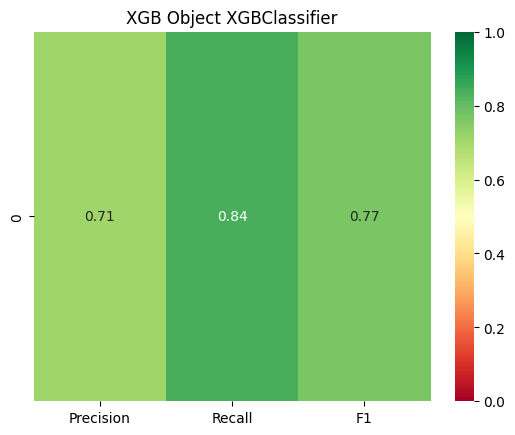

Simba Object
XGB odour
[[0.7580049261083743, 0.793425717048018, 0.7753109746496614]]


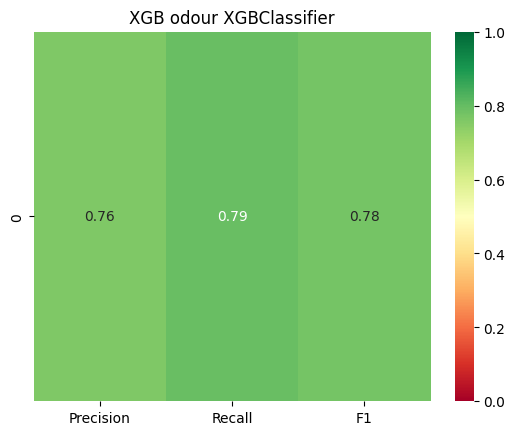

Simba odour


In [118]:

import matplotlib.pyplot as plt
import seaborn as sns

def classification_report(y_true, y_pred=None, clf=None, X_data=None, title=''):
    assert (clf and X_data) or y_pred
    assert not((clf or X_data) and y_pred)
    # Make a heat map of classifier measures.
    if clf:
        y_pred = clf.predict(X_data)
    f1_data: PartialResults = build_partial_result(y_true, y_pred)
    # We actually don't care about the f1 score on the majority class.  Will only report class(es) of interest.
    # TODO: We're going to include the confusion matrix as a subplot!
    plot_data = [[f1_data.precision, f1_data.recall, f1_data.f1]]
    print(plot_data)
    columns = ['Precision', 'Recall', 'F1']
    data = pd.DataFrame(plot_data, columns=columns)
    # sns.heatmap(data, vmin=0.0, vmax=1.0, annotate=True)
    ax = plt.axes()
    sns.heatmap(data, vmin=0.0, vmax=1.0, cmap='RdYlGn', annot=True) #, annotate=True)
    ax.set_title(title)
    plt.show()
    # plt.xticks(range(len(columns)), columns)
    # plt.yticks([])
    # plt.imshow(plot_data, cmap='Greens', vmin=0.0, vmax=1.0, annotate=True)
    # plt.show()

for holdout_dataset, xgb_clf, task_name in [
        (holdout_object_dataset, xgb_object_clf, 'XGB Object'),
        (holdout_object_dataset, simba_object_clf, 'Simba Object'),
        (holdout_odour_dataset, xgb_odour_clf, 'XGB odour'),
        (holdout_odour_dataset, simba_odour_clf, 'Simba odour'),
    ]:
    print(task_name)
    y_true = []
    from collections import OrderedDict
    y_preds = OrderedDict() # Will be a list with each step of processing in it
    for video_data in holdout_dataset.per_video_data_classes:
        y_true.extend(video_data.y_binary)
        for step_name, data_thing in video_data.model_result_labels[get_classifier_desc(xgb_clf)].items():
            if step_name not in y_preds:
                y_preds[step_name] = []
            y_preds[step_name].extend(data_thing.y_binary)

    for step_name, y_pred in y_preds.items():
        classification_report(y_true, y_pred, title=task_name + ' ' + step_name)
        break


# Computing Final Results.
Results will be aggregated in a hierarchy of classes like so:

AggregationFunction: Defines the measureable we wish to compute;
    - PerVideoResults: Similar to before, we store reusult dataframes pervideo, then classifier, then step.  
                       We want to see how the different stages in post processing effect our various measureables.

In [133]:



# Lets produce our own data as best we can.
# Get the results we have per video, grab the per object results, and then use the 30 frames per second assumtion
# to caclulate the total time at each object in seconds.  Can also break this down by minute later BUT need to confirm
# with Tim how the data is setup!! Because given 30 frames per second assumption, these videos are (7200/30)/60 = 4 minutes long
# which doesn't make sense with the stop watch data provided that makes it seem there are 10 minutes of video in each!!
# (5 minutes per animal, with 2 animals per video being given 1 treatment!)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



def build_results_df_from_agg_funcs_and_per_video_data(per_video_data_classes: list[PerVideoDataClass],
                    agg_funcs, per_minute, classifier_desc, pipeline_model_step=None):
    """ Dataset will have precomputed results for all the classifiers and videos of interest. """
    # NOTE: No rat_id_col for these results dataframes, we can map the videoname -> rat_id via the 
    #       stopwatch dataframe later if we wish.
    assert isinstance(agg_funcs, list)
    if pipeline_model_step is None:
        # Identity, default pipeline step
        pipeline_model_step = classifier_desc
    video_col = 'video_name'
    rat_id_col = 'rat_id'
    object_col = 'object'
    minute_col = 'min'
    if per_minute:
        cols = [video_col, object_col, minute_col]
    else:
        cols = [video_col, object_col]
    cols += [func.__name__ for func in agg_funcs]

    model_res_df = pd.DataFrame([], columns=cols)
    golden_res_df = pd.DataFrame([], columns=cols)
    print(f':::: Processing {classifier_desc};{pipeline_model_step} model ::::')

    for per_video_data in per_video_data_classes:
        print('Processing:', per_video_data.video_name)
        y_multi_golden = per_video_data.y_multi

        results: ModelResultLabels = per_video_data.model_result_labels[classifier_desc][pipeline_model_step]
        # Let's just do the base classifier for now??? Or lets do all 3??
        # print(results.multi_label_results)
        y_multi = results.y_multi
        # TODO:  Here we need to take 1 minute 'bites' of the data!
        #        We will build up a dataframe with the same format was what Tim provided!
        unique_labels = numpy.unique(y_multi)

        if per_minute:
            start = 0
            frame_rate = 30 # frames per second
            frames_in_1_minute = frame_rate * 60
            end = frames_in_1_minute
            minute_number = 1 # Puny human 1 based indexing
            while start < len(y_multi):
                if end > len(y_multi):
                    print('Maybe going to have a problem, end is', end, 'and y_multi len is ', len(y_multi))
                y_multi_cur = y_multi[start:end] # Remember, exclusive indexing
                y_multi_golden_cur = y_multi_golden[start:end] # Remember, exclusive indexing
                for label in unique_labels:
                    model_agg_func_results = {}
                    golden_agg_func_results = {}
                    if label == 0:
                        # Majority label, no interaction
                        continue
                    # golden_interaction_times[label] = (y_multi_golden_cur == label).sum() / video_frame_rate
                    for agg_func in agg_funcs:
                        model_agg_func_results[agg_func.__name__] = agg_func(y_multi_cur, label)
                        golden_agg_func_results[agg_func.__name__] = agg_func(y_multi_golden_cur, label)
                    model_res_df = model_res_df.append({
                        video_col: per_video_data.video_name,
                        object_col: label,
                        minute_col: minute_number,
                        **model_agg_func_results},
                        ignore_index=True)
                    golden_res_df = golden_res_df.append({
                        video_col: per_video_data.video_name,
                        object_col: label,
                        minute_col: minute_number,
                        **golden_agg_func_results},
                        ignore_index=True)
                minute_number += 1
                start = end
                end += frames_in_1_minute
        else:
            for label in unique_labels:
                model_agg_func_results = {}
                golden_agg_func_results = {}
                if label == 0:
                    # Majority label, no interaction
                    continue
                # golden_interaction_times[label] = (y_multi_golden_cur == label).sum() / video_frame_rate
                for agg_func in agg_funcs:
                    model_agg_func_results[agg_func.__name__] = agg_func(y_multi, label)
                    golden_agg_func_results[agg_func.__name__] = agg_func(y_multi_golden, label)
                model_res_df = model_res_df.append({
                    video_col: per_video_data.video_name,
                    object_col: label,
                    **model_agg_func_results},
                    ignore_index=True)
                golden_res_df = golden_res_df.append({
                    video_col: per_video_data.video_name,
                    object_col: label,
                    **golden_agg_func_results},
                    ignore_index=True)
    return model_res_df, golden_res_df


def build_agg_sum_total_time(video_frame_rate):
    def agg_sum_total_time(y_multi, label):
        return (y_multi == label).sum() / video_frame_rate
    return agg_sum_total_time

def build_agg_num_interaction_bouts():
    def agg_num_interaction_bouts(y_multi: np.ndarray, label):
        assert isinstance(y_multi, np.ndarray) and y_multi.ndim == 1, 'If we get a list of arrays or an array with more dims we will have to think harder.'
        # Find indexes associated with this label.
        # If our vector looks like this:
        # [0,0,2,2,2,0,0,2]
        # Then for label 2 we will get indexes:
        # [2,3,4,7]
        # The diffs here will be:
        # [1,1,3]
        # With each 1 associated with at least 2 frames that are part of the same bout.
        # So we bound the number of entries in the diff array that are greater than 1,
        # and this gives the number of bouts.
        idxes = np.where(y_multi == label)[0] # HACKS: The [0] is required because of the way
        diffs = np.diff(idxes)
        num_bouts = (diffs > 1).sum()
        return num_bouts
    return agg_num_interaction_bouts

def build_agg_mean_bout_duration(video_frame_rate):
    def agg_mean_bout_duration(y_multi: np.ndarray, label):
        assert isinstance(y_multi, np.ndarray) and y_multi.ndim == 1, 'If we get a list of arrays or an array with more dims we will have to think harder.'
        # like agg_num_interaction_bouts
        idxes = np.where(y_multi == label)[0]
        diffs = np.diff(idxes)
        num_bouts = (diffs > 1).sum()
        # Like agg_sum_total_time
        total_time = (y_multi == label).sum() / video_frame_rate
        if num_bouts > 0:
            assert total_time > 0
            # Combine them, and that's the mean
            return total_time / num_bouts
        else:
            return 0
    return agg_mean_bout_duration

def build_approach_latency(video_frame_rate):
    def approach_latency(y_multi: np.ndarray, label):
        idxes = np.where(y_multi == label)[0]
        if idxes.size > 0:
            first_interaction = idxes[0]
            # Time in seconds before first interaction
            total_time = first_interaction / video_frame_rate
            return total_time
        return None # No interaction with this object.  Return NaN might be better
    return approach_latency

def build_agg_function_dfs(clf_dir_name, classifier, data_split_dir_name, dataset):
    # training_model_res_per_minute_df, training_golden_res_per_minute_df = build_results_df_from_agg_funcs_and_per_video_data(
    #         training_dataset.per_video_data_classes,
    #         classifier_desc=get_classifier_desc(xgb_clf),
    #         per_minute=True,
    #         pipeline_model_step=None,
    #         agg_funcs=[
    #             build_agg_sum_total_time(30),
    #             build_agg_mean_bout_duration(30),
    #             build_agg_num_interaction_bouts(),
    #         ]
    #     )
    classifier_desc = get_classifier_desc(classifier) 
    if classifier is None:
        pipeline_model_step = classifier_desc
    else:
        pipeline_model_step = classifier.__class__.__name__

    # holdout_model_res_per_minute_df, holdout_golden_res_per_minute_df = build_results_df_from_agg_funcs_and_per_video_data(
    #         dataset.per_video_data_classes,
    #         classifier_desc=classifier_desc,
    #         per_minute=True,
    #         pipeline_model_step=pipeline_model_step, # NOTE: ONLY CALCULATING FOR RAW MODEL RIGHT NOW! Not worried about other steps
    #         agg_funcs=[
    #             build_agg_sum_total_time(30),
    #             build_agg_mean_bout_duration(30),
    #             build_agg_num_interaction_bouts(),
    #         ]
    #     )

    holdout_model_res_per_video_df, holdout_golden_res_per_video_df = build_results_df_from_agg_funcs_and_per_video_data(
            dataset.per_video_data_classes,
            classifier_desc=classifier_desc,
            per_minute=False,
            pipeline_model_step=pipeline_model_step,
            agg_funcs=[
                build_agg_sum_total_time(30),
                build_agg_mean_bout_duration(30),
                build_agg_num_interaction_bouts(),
                build_approach_latency(30)
            ]
        )

    def to_csv(df, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        df.to_csv(path)

    # to_csv(holdout_model_res_per_minute_df, os.path.join('hackathon', 'notebook_result_csvs', data_split_dir_name, clf_dir_name, 'holdout_model_results_per_minute.csv'))
    # to_csv(holdout_golden_res_per_minute_df, os.path.join('hackathon', 'notebook_result_csvs', data_split_dir_name, clf_dir_name, 'holdout_golden_results_per_minute.csv'))
    to_csv(holdout_model_res_per_video_df, os.path.join('hackathon', 'notebook_result_csvs', data_split_dir_name, clf_dir_name, 'holdout_model_results_per_video.csv'))
    to_csv(holdout_golden_res_per_video_df, os.path.join('hackathon', 'notebook_result_csvs', data_split_dir_name, clf_dir_name, 'holdout_golden_results_per_video.csv'))
    return AggFuncDfs(
        # holdout_model_res_per_minute_df, holdout_golden_res_per_minute_df, 
        holdout_model_res_per_video_df, holdout_golden_res_per_video_df)

AggFuncDfs = namedtuple('AggFuncDfs', 
    # 'holdout_model_per_minute holdout_golden_per_minute holdout_model_per_video holdout_golden_per_video')
    'holdout_model_per_video holdout_golden_per_video')



In [134]:

xgb_odour_dfs = build_agg_function_dfs('xgb_clf', xgb_odour_clf, 'odour', holdout_odour_dataset)
# simba_odour_dfs = build_agg_function_dfs('simba_clf', simba_odour_clf, 'odour', holdout_odour_dataset)
xgb_object_dfs = build_agg_function_dfs('xgb_clf', xgb_object_clf, 'object', holdout_object_dataset)
# simba_object_dfs = build_agg_function_dfs('simba_clf', simba_object_clf, 'object', holdout_object_dataset)


:::: Processing XGBClassifier_odour;XGBClassifier model ::::
Processing: 08102021_DOT_Rat7_8
Processing: 08122021_IOT_Rat11_12
Processing: 2022-06-12_NOD_DOT_17
:::: Processing XGBClassifier_object;XGBClassifier model ::::
Processing: 03142021_NOB_DOT_5_upsidedown
Processing: 08092021_IOT_Rat7_8
Processing: 2022-06-11_NOB_IOT_2(upsidedown)_WC
Processing: 2022-06-17_NOB_IOT_4
Processing: 2022-06-20_NOB_IOT_1
Processing: 2022-06-20_NOB_IOT_3
Processing: 2022-06-21_NOB_DOT_24
Processing: 2022-06-23_NOB_DOT_1
Processing: 2022-06-23_NOB_IOT_4
Processing: 2022-06-24_NOB_IOT_22 (2)
Processing: 2022-06-24_NOB_IOT_22
Processing: 2022-06-24_NOB_IOT_24
Processing: 2022-06-26_NOB_DOT_2
Processing: 2022-06-26_NOB_DOT_6
Processing: 2022-06-26_NOB_IOT_5 (2)
Processing: 2022-06-27_NOB_DOT_20
Processing: 2022-06-27_NOB_IOT_21


In [136]:

simba_object_dfs = build_agg_function_dfs('simba_clf', None, 'object', simba_prelabeled_dataset)

:::: Processing simba-RF-precomputed;simba-RF-precomputed model ::::
Processing: 03142021_NOB_DOT_3_upsidedown
Processing: 03142021_NOB_DOT_5_upsidedown
Processing: 03142021_NOB_DOT_9_upsidedown
Processing: 03142021_NOB_IOT_11_upsidedown
Processing: 03142021_NOB_IOT_1_upsidedown
Processing: 03142021_NOB_IOT_7_upsidedown
Processing: 03152021_NOB_DOT_2
Processing: 03152021_NOB_IOT_10
Processing: 03152021_NOB_IOT_12
Processing: 03152021_NOB_IOT_6
Processing: 03152021_NOB_IOT_8
Processing: 03162021_NOB_DOT_10_upsidedown
Processing: 03162021_NOB_DOT_4_upsidedown
Processing: 03162021_NOB_DOT_8_upsidedown
Processing: 03162021_NOB_IOT_12_upsidedown
Processing: 03162021_NOB_IOT_2_upsidedown
Processing: 03162021_NOB_IOT_6_upsidedown
Processing: 03172021_NOB_DOT_1_upsidedown
Processing: 03172021_NOB_DOT_5_upsidedown
Processing: 03172021_NOB_IOT_11_upsidedown
Processing: 03172021_NOB_IOT_3_upsidedown
Processing: 03172021_NOB_IOT_7_upsidedown
Processing: 03182021_NOB_DOT_1_upsidedown
Processing: 03

# Stop Watch Data

In [152]:
# Open the csv file, flatten it into a dataframe, print that dataframe out for reference, then calculate statistics.

stop_watch_csv = os.path.join('hackathon', 'Iteration_2_withROI', 'models', 'holdout_stopwatch_TJO.csv')
stop_watch_interaction_times_df = pd.read_csv(stop_watch_csv, index_col=None)
stop_watch_interaction_times_df.rename(columns={'value':'agg_sum_total_time'}, inplace=True)

# del stop_watch_interaction_times_df # Not using right now, was per minute and not aggregating because Pandas

In [153]:
xgb_odour_dfs.holdout_golden_per_video.head()

,video_name,object,agg_sum_total_time,agg_mean_bout_duration,agg_num_interaction_bouts,approach_latency
0,08102021_DOT_Rat7_8,1,1.633333,1.633333,1,38.066667
1,08102021_DOT_Rat7_8,2,6.833333,1.138889,6,35.466667
2,08102021_DOT_Rat7_8,3,14.633333,2.438889,6,2.400000
3,08102021_DOT_Rat7_8,4,4.266667,1.066667,4,46.166667
4,08102021_DOT_Rat7_8,5,5.233333,1.308333,4,16.233333


In [156]:
# full_df = stop_watch_interaction_times_df.merge(
#     xgb_object_dfs.holdout_golden_per_minute, # TODO: If you want the stop watch data... this is the easiest (haha) way to aggregate that data.. by minute
#      on=('video_name', 'object', 'min'),
#      suffixes=['_stopwatch', '_model'], validate='1:1')
#     #  lsuffix='stopwatch',
#     #  rsuffix='model')
# full_df

KeyError: 'min'

In [149]:
video_col = 'video_name' # ????

def plot_model_vs_holdout(model_dfs):
    videos_to_consider = set(model_dfs.holdout_model_per_video[video_col]) & \
                        set(model_dfs.holdout_golden_per_video[video_col])
    raise NotImplementedError()

plot_model_vs_holdout(xgb_object_dfs)


NotImplementedError: 

In [150]:
# xgb_holdout_model_pivot_table, xgb_holdout_golden_pivot_table, stop_watch_interaction_times_pivot_table

object
1   -1.288889
2    0.822222
3   -0.311111
4   -0.277778
5    0.755556
6   -0.644444
dtype: float64 object
1    2.377284
2    2.019443
3    0.300617
4    1.035660
5    0.512438
6    1.033513
dtype: float64


Text(0.5, 1.0, 'Error Between Carefully Labeled Data and XGB Labeled Data')

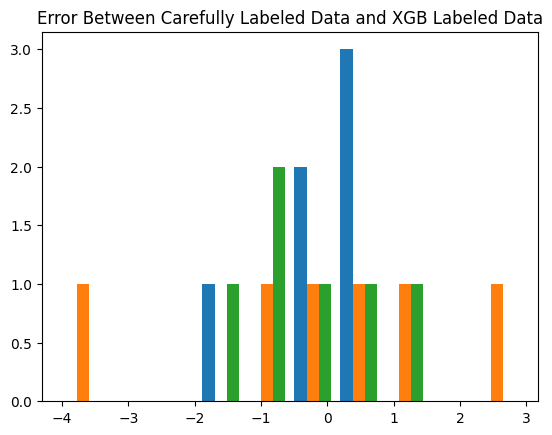

In [ ]:
import matplotlib.pyplot as plt
print(golden_vs_model_pivot_table.mean(axis=1), golden_vs_model_pivot_table.std(axis=1))
plt.hist(golden_vs_model_pivot_table)
plt.title('Error Between Carefully Labeled Data and XGB Labeled Data')

object
1   -0.033333
2    0.677778
3    1.988889
4    0.322222
5    1.911111
6    0.777778
dtype: float64 object
1    0.768838
2    1.384170
3    1.948314
4    3.015577
5    1.652383
6    0.732070
dtype: float64


Text(0.5, 1.0, 'Error Between Carefully Labeled Data and Stopwatch Labeled Data')

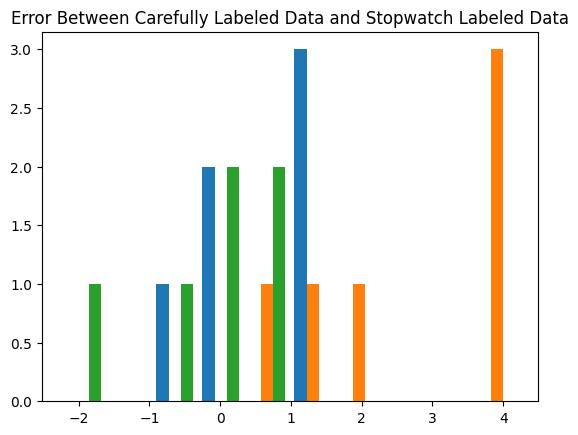

In [ ]:
print(golden_vs_stop_watch_pivot_table.mean(axis=1), golden_vs_stop_watch_pivot_table.std(axis=1))
plt.hist(golden_vs_stop_watch_pivot_table)
plt.title('Error Between Carefully Labeled Data and Stopwatch Labeled Data')

In [ ]:
_m_df = xgb_odour_dfs.holdout_model_per_video
_g_df = xgb_odour_dfs.holdout_golden_per_video

agg_label = 'approach_latency'
model_suffix = '_model1'
golden_suffix = '_golden'
_df = _m_df.merge(_g_df, on=['video_name', 'object'], suffixes=[model_suffix, golden_suffix])

_df['latency_diffs'] = _df[agg_label + model_suffix] - _df[agg_label + golden_suffix]
_df

# Load novel labels csv
novel_labels_df = pd.read_csv(os.path.join('hackathon', 'OBJ-novelposition.csv'))
# TODO: Verify video names are the same

# TODO: Map old video names => new video names in _df, so they match novel_labels
_temp_name_map_df = pd.DataFrame(
    {
        'new': ['03142021_NOB_DOT_3_upsidedown', '2022-06-27_NOB_DOT_22'],
        'old': ['08102021_DOT_Rat7_8', '2022-06-12_NOD_DOT_17'],
    }
    )

_df = _df.replace(dict(zip(_temp_name_map_df.old, _temp_name_map_df.new)))

_df = _df.merge(novel_labels_df, on='video_name')
_df

# NEXT: Group by video, take only where novel object = (the one from the csv)
#       OR: left_join, then take where the two columns are equal

,video_name,object,agg_sum_total_time_model1,agg_mean_bout_duration_model1,agg_num_interaction_bouts_model1,approach_latency_model1,agg_sum_total_time_golden,agg_mean_bout_duration_golden,agg_num_interaction_bouts_golden,approach_latency_golden,latency_diffs,novel_object
0,03142021_NOB_DOT_3_upsidedown,1,1.933333,0.386667,5,38.100000,1.633333,1.633333,1,38.066667,0.033333,4
1,03142021_NOB_DOT_3_upsidedown,2,7.300000,0.384211,19,35.500000,6.833333,1.138889,6,35.466667,0.033333,4
2,03142021_NOB_DOT_3_upsidedown,3,14.133333,0.565333,25,2.233333,14.633333,2.438889,6,2.400000,-0.166667,4
3,03142021_NOB_DOT_3_upsidedown,4,4.566667,0.380556,12,46.166667,4.266667,1.066667,4,46.166667,0.000000,4
4,03142021_NOB_DOT_3_upsidedown,5,3.633333,0.279487,13,16.466667,5.233333,1.308333,4,16.233333,0.233333,4
5,03142021_NOB_DOT_3_upsidedown,6,8.800000,0.400000,22,7.466667,6.000000,0.857143,7,7.300000,0.166667,4
6,2022-06-27_NOB_DOT_22,1,7.300000,0.331818,22,7.333333,6.900000,0.862500,8,7.500000,-0.166667,2
7,2022-06-27_NOB_DOT_22,2,4.500000,0.250000,18,2.700000,5.366667,2.683333,2,112.466667,-109.766667,2
8,2022-06-27_NOB_DOT_22,3,10.266667,1.026667,10,0.033333,10.166667,2.033333,5,17.566667,-17.533333,2
9,2022-06-27_NOB_DOT_22,4,6.600000,1.100000,6,10.900000,6.700000,1.675000,4,60.800000,-49.900000,2
